#**Facial Recognition Model**

We'll be working with the FER 2013 database, which contains 35887 images obtained through Google via scraping, which have been converted into 48x48 pixel grayscale, centered images and split into seven emotions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, layers, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow import expand_dims
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications.resnet import preprocess_input
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow import keras
import cv2
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

Way to import the csv from our google cloud

In [2]:
!pip install -U -q PyDrive
  
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
  
  
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
link = 'pathtofile'
  
import pandas as pd
  
# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('icml_face_data.csv')  
  
data = pd.read_csv('icml_face_data.csv')

In [4]:
len(data) - len(data.drop_duplicates())

1234

We found that our dataframe contains 1234 duplicates so we remove them.

We also change the column names to be more usable

In [5]:
data.drop_duplicates(inplace=True)
data.reset_index(drop = True, inplace = True)
data.columns=['emotion', 'usage', 'pixels']

In [6]:
df = data.copy()
df.emotion.value_counts() / len(df)

3    0.255649
6    0.176175
4    0.172481
2    0.142123
0    0.138516
5    0.100886
1    0.014169
Name: emotion, dtype: float64

We will remove one emotion because we have very little data about it.

Since our pixels are stored in string form we will convert them to a 48x48 numpy array

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


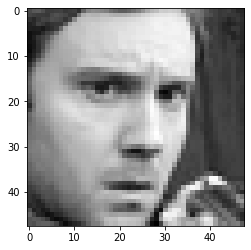

In [7]:
df = df[df.emotion != 1]
df.reset_index(drop = True, inplace = True)

for i in range(2,7):
  df['emotion'] = np.where((df.emotion == i), i - 1, df.emotion)

for i in range(len(df.pixels)):
  test_str = df.pixels[i]
  test_list = test_str.split(' ')
  df.pixels[i] = np.asarray(test_list).reshape(48,48).astype(int)
plt.imshow(df.pixels[0], cmap='gray')

We split the dataset into train and test.

Our dataframe already had a column that "splited" it so we do the split according to this and then we remove the column.

In [8]:
df_train = df[df['usage']=='Training']
df_train.reset_index(drop = True, inplace = True)

df_test = df[df['usage']=='PublicTest']
df_test = df_test.append(df[df['usage']=='PrivateTest'])
df_test.reset_index(drop = True, inplace = True)

df_train.drop(columns = 'usage', inplace = True)
df_test.drop(columns = 'usage', inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


We split our train and test dataset into X and y (images and emotion)

In [9]:
X_train = df_train.pixels
y_train = df_train.emotion
X_test = df_test.pixels
y_test = df_test.emotion

X_train = [X_train[i] for i in range(len(X_train))] # create a list with all our records
X_train = np.dstack(X_train)
X_train = np.rollaxis(X_train, -1)

X_test = [X_test[i] for i in range(len(X_test))] # create a list with all our records
X_test = np.dstack(X_test)
X_test = np.rollaxis(X_test, -1)

If we will use categorical_crossentropy as a loss later in our model we will convert our train and test targets to binary class matrixes

In [10]:
y_train = to_categorical(y_train, num_classes=6)
y_test = to_categorical(y_test, num_classes=6)

We add a dimension and normalize our data

In [11]:
X_train = np.expand_dims(X_train, axis = -1)
X_test = np.expand_dims(X_test, axis = -1)

X_train = X_train / 255.
X_test = X_test / 255.

We structure our model (it's not exactly the one we used cause it's lost somewhere in the several notebooks 😅)

In [12]:
reg_l2 = regularizers.L2(0.01)

model= Sequential()
model.add(layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, kernel_size=(5,5), padding='same', activation='relu', kernel_regularizer=reg_l2))
model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(512, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=reg_l2))
model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(3)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(512, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=reg_l2))
model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(3)))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten()) 
model.add(layers.Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Dense(1408,activation = 'relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(6, activation='softmax'))

We compile our method using either sparse categorical crossentropy or categorical crossentropy. We choose categorical crossentropy if we have one hot encoded our targets

In [13]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics='accuracy')

We define our callbacks.

ReduceLROnPlateu will reduce the learning rate during training according to our parameters.

ModelCheckpoint will save a model or the weights at some interval that are considered the best, which we can later use. 

In [14]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 2,verbose = 1,factor = 0.70, min_lr = 1e-10)

mcp = ModelCheckpoint(filepath = 'model.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

es = EarlyStopping(patience=15, verbose = 1, restore_best_weights = True)

We finally fit the model

In [15]:
history = model.fit(X_train, y_train,
            batch_size=96, 
            epochs=200, 
            validation_split=0.3,
            callbacks=[lrd, mcp, es])

Epoch 1/200
198/198 [==============================] - 44s 55ms/step - loss: 8.3993 - accuracy: 0.2028 - val_loss: 5.1768 - val_accuracy: 0.2680
Epoch 2/200
198/198 [==============================] - 9s 46ms/step - loss: 3.8413 - accuracy: 0.2321 - val_loss: 3.2305 - val_accuracy: 0.1387
Epoch 3/200
198/198 [==============================] - 9s 46ms/step - loss: 2.8010 - accuracy: 0.2934 - val_loss: 3.1810 - val_accuracy: 0.2697
Epoch 4/200
198/198 [==============================] - 9s 46ms/step - loss: 2.6444 - accuracy: 0.3829 - val_loss: 3.0898 - val_accuracy: 0.2134
Epoch 5/200
198/198 [==============================] - 9s 46ms/step - loss: 2.5508 - accuracy: 0.4348 - val_loss: 2.9718 - val_accuracy: 0.2739
Epoch 6/200
198/198 [==============================] - 9s 46ms/step - loss: 2.4617 - accuracy: 0.4584 - val_loss: 2.6108 - val_accuracy: 0.4353
Epoch 7/200
198/198 [==============================] - 9s 46ms/step - loss: 2.5308 - accuracy: 0.4664 - val_loss: 2.7289 - val_accuracy

We plot the fit history to see the accuracies and the losses

In [16]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<matplotlib.axes._subplots.AxesSubplot at 0x7efb90367a50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7efb90323990>)

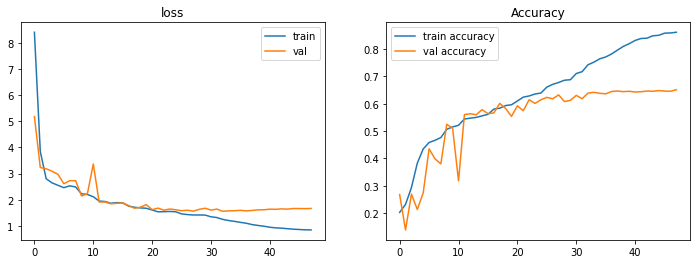

In [17]:
plot_history(history)

Model Evaluation and saving

In [18]:
#model.load_weights('model.h5')   #uncomment to use best pretrained weights
model.evaluate(X_test, y_test)
#model.save('path')

220/220 [==============================] - 2s 8ms/step - loss: 1.5433 - accuracy: 0.6436


[1.5432934761047363, 0.6435685753822327]

Way to load a pretrained model

In [19]:
#model = tf.keras.models.load_model('modelpath')

We save the probabilities and our predictions to use them later in evaluation

In [20]:
y_prob = model.predict(X_test)
y_pred = np.argmax(y_prob, axis=1)

# Evaluation Process

Using a Confusion Matrix (original emotions in y axis, predicted emotions in x axis)

In [23]:
emotions = {0:'angry', 1:'scared', 2:'happy', 3:'sad', 4:'surprised', 5:'neutral'}

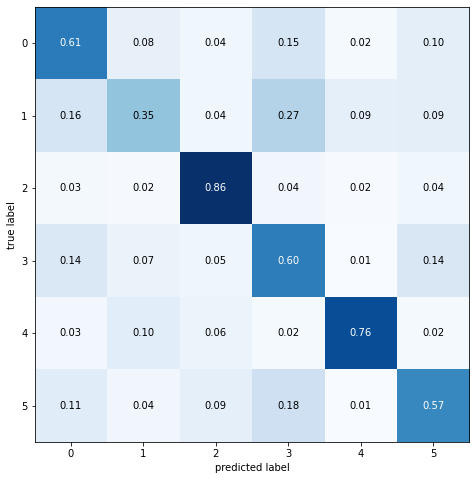

In [24]:
conf_mat = confusion_matrix(df_test.emotion, y_pred)
pd.DataFrame(conf_mat, columns=emotions.values(), index=emotions.values())

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                figsize=(8, 8))
fig.show()

Using a Classification Report

In [26]:
print(classification_report(df_test.emotion, y_pred, target_names=emotions.values()))

              precision    recall  f1-score   support

       angry       0.52      0.61      0.56       951
      scared       0.53      0.35      0.42      1016
       happy       0.84      0.86      0.85      1772
         sad       0.51      0.60      0.55      1244
   surprised       0.79      0.76      0.77       814
     neutral       0.61      0.57      0.59      1231

    accuracy                           0.64      7028
   macro avg       0.63      0.62      0.62      7028
weighted avg       0.64      0.64      0.64      7028



Using GradCAM.

GradCam shows the areas targeted by our model to find a prediction.

The areas shown vary according to the pool size of our Max pooling 2D layers.


In [27]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()
            
    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
        
    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,self.model.output]
       )
           
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
            grads = tape.gradient(loss, convOutputs)

            castConvOutputs = tf.cast(convOutputs > 0, "float32")
            castGrads = tf.cast(grads > 0, "float32")
            guidedGrads = castConvOutputs * castGrads * grads
            convOutputs = convOutputs[0]
            guidedGrads = guidedGrads[0]

            weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
            cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

            (w, h) = (image.shape[2], image.shape[1])
            heatmap = cv2.resize(cam.numpy(), (w, h))
            numer = heatmap - np.min(heatmap)
            denom = (heatmap.max() - heatmap.min()) + eps
            heatmap = numer / denom
            heatmap = (heatmap * 255).astype("uint8")
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap = cv2.COLORMAP_VIRIDIS):
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        return (heatmap, output)

Check the original image, the GradCam image and the distribution of the predictions for 10 different images in our test set.

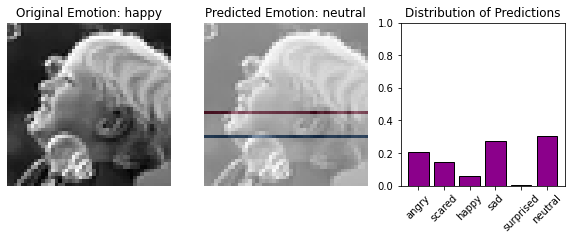

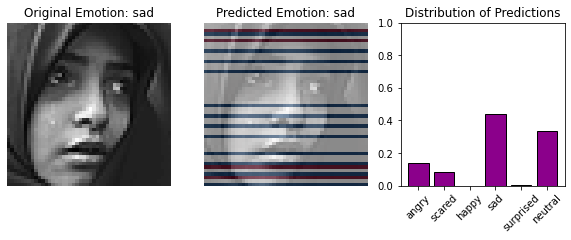

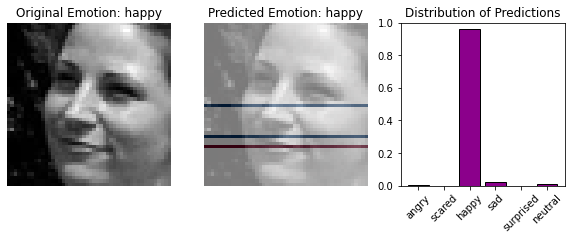

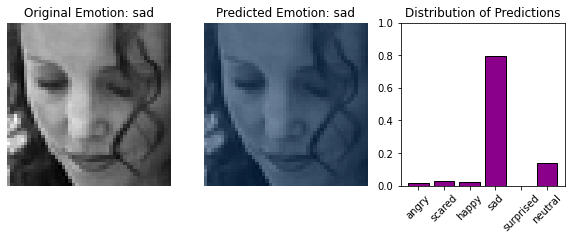

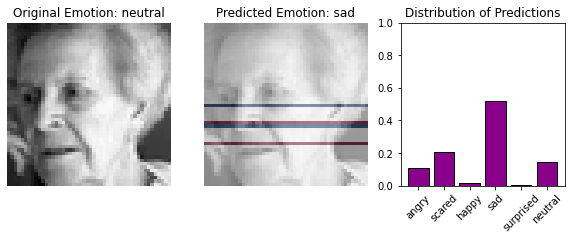

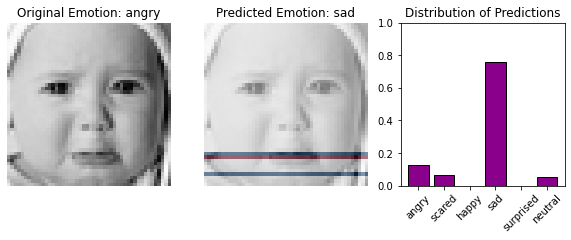

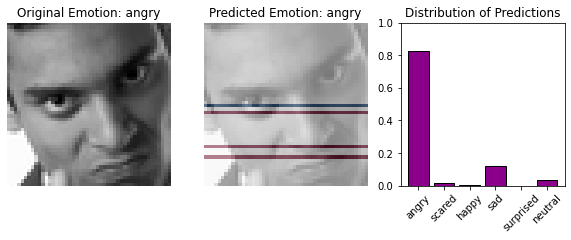

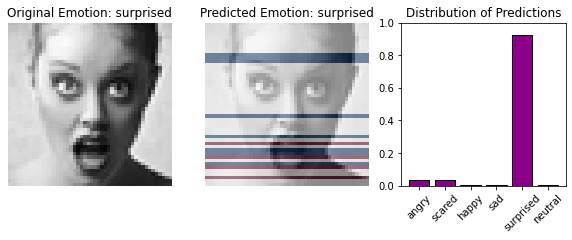

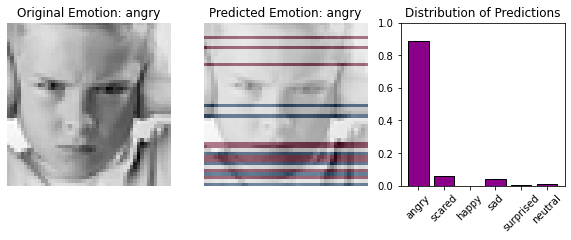

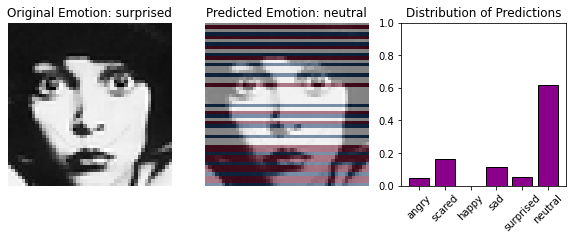

In [31]:
imgs = np.random.randint(low=0, high=len(X_test), size=10)


for n in imgs:
    img = X_test[n,:,:,0]
    
    plt.figure(figsize=[10,3])
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='binary_r')
    plt.title(f'Original Emotion: {emotions[df_test.emotion[n]]}')
    plt.axis('off')
    
    cam = GradCAM(model, y_pred[n])
    heatmap = cam.compute_heatmap(img.reshape(1,48,48,1))
    
    plt.subplot(1, 3, 2)
    plt.imshow(img, cmap='binary_r')
    plt.imshow(heatmap, alpha=0.5, cmap='RdBu_r')
    plt.title(f'Predicted Emotion: {emotions[y_pred[n]]}')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.bar(emotions.values(), y_prob[n, :], color='darkmagenta', edgecolor='k')
    plt.xticks(rotation=45)
    plt.ylim([0,1])
    plt.title('Distribution of Predictions')
    plt.show()

# Predictions

Create the functions for our image proccesing and emotion prediction.

haarscade needs to be loaded.

In [32]:
def user_pic_preproc(img, bor=0):
    '''convert user picture to grayscale, identify and extract the face and compress to 48 x 48 pixels'''
    
    face_model = cv2.CascadeClassifier('/content/drive/MyDrive/haarcascade_frontalface_default.xml')
    print(face_model)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_model.detectMultiScale(gray, 1.2, 15)
   
        # set additional border to face detection for picture extraction 
    x, y, w, h = faces[0]
    x2 = int(round((x - bor * w), 0))  # x 
    y2 = int(round((y - bor * h), 0))  # y
    w2 = int(round((w * (1 + 2 * bor)), 0))  # width of extraction
    h2 = int(round((h * (1 + 2 * bor)), 0))  # height of extraction
    
    img_face = gray[y2 : y2 + h2, x2 : x2 + w2]
    img_resized = cv2.resize(img_face, (48, 48), interpolation = cv2.INTER_AREA)
    img_expanded = np.expand_dims(img_resized, axis = [0, -1])
    
    return img_expanded


def load_trained_model(path):
    return keras.models.load_model(path)

def predict_emotion(model, img):
    emotions_2 = {0:'angry', 1:'scared', 2:'happy', 3:'sad', 4:'surprised', 5:'neutral'}
    results = model.predict(img)
    if len(results) > 0:
        ind = np.argmax(results[0])
        predicted_emotion = emotions_2.get(ind)
    else: 
        predicted_emotion = 'Happy'  # hard coded in case no face recognition for the sake of testing
    return results, predicted_emotion

Show our processed image, the GradCam image and the distribution of the predictions.

<CascadeClassifier 0x7efb7e47e530>
angry
(1, 48, 48, 1)


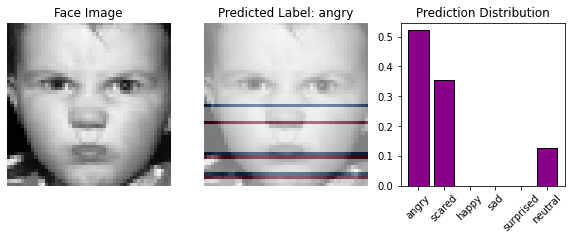

In [42]:
img = cv2.imread('/content/2190903226_1be8b3766b_n.jpg')
img2 = user_pic_preproc(img)
results, emotion = predict_emotion(model, img2)
print(emotion)



plt.figure(figsize=[10,3])

plt.subplot(1, 3, 1)
plt.imshow(img2[0,:,:,0], cmap='binary_r')
plt.title('Face Image')
plt.axis('off')
print(img2.shape)

cam = GradCAM(model, np.argmax(results[0]))
heatmap = cam.compute_heatmap(img2)

plt.subplot(1, 3, 2)
plt.imshow(img2[0,:,:,0], cmap='binary_r')
plt.imshow(heatmap, alpha=0.5, cmap='RdBu_r')
plt.title(f'Predicted Label: {emotion}')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.bar(emotions.values(), results[0,:], color='darkmagenta', edgecolor='k')
plt.xticks(rotation=45)
plt.title('Prediction Distribution')
plt.show()

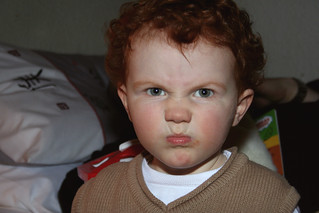

In [43]:
from IPython.display import Image
Image('/content/2190903226_1be8b3766b_n.jpg')